<div style="text-align:center"><span style="color:black; font-family:Times New Roman; font-size:3em;"> Next basket recommendation  </span></div>

<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Introduction </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;padding-left:3em;padding-right:3em;"> Prediction of reorder products for a user’s next purchase  becomes an increasing concern in online electronic business and retail shopping market. Hence, successfully capturing the buying pattern of an individual user is critical to this type of recommendation task.  In this project, I used Instacart’s data provided by Kaggle (https://www.kaggle.com/c/instacart-market-basket-analysis/data) to predict which previously purchased products will be in a user’s next order, based on customers’ purchase history. 
<br \>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
In order to capture sequential behavior of a user and users’ general tastes, I applied feature engineering to extract representative features from the users’ whole purchase behavior. Meanwhile, I employed a neural network to model complicated interaction among users and products. The result shows this approach can be capable of generating accurate recommendation about products that a user may want to purchase again.  
 </span></div>

<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Data exploration  </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;padding-left:3em;padding-right:3em;"> The dataset for this project is a relation set of files involving customers’ order history. The dataset contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, there are 4 to 100 orders. The data files describe below:
<br \>'aisles.csv'  :
<br \>
Each entity  shows an unique aisle ID (aisle_id) and an associated product aisle name (aisle).
<br \>
'departments.csv': 
<br \>
Each entity  shows an unique department ID (department_id) and an associated product department name (department).
<br \>
'products.csv' :
<br \>
Each entity shows an unique product ID (product_id) with an associated product name (product_name), an aisle ID (aisle_id) and a department ID (department_id).
<br \>
'order_products\__prior.csv': 
<br \>
This file contains previous order information for all users. Each entity shows an order ID (order_id), a purchased product ID (product_id), the sequence order of adding to the cart on this purchase for this product (add_to_cart_order), and whether this product was reordered (reordered). 
<br \>
'order_products__train.csv':
<br \>
This file contains the latest order information for the users of the training set. Each entity includes order_id,  product_id, add_to_cart_order and reordered.
<br \>
'orders.csv'               :
<br \>
Each entity shows an order ID (order_id) purchased by a user (user_id) on the n-th order (order_number) of this user, the days since the previous order (days_since_prior_order), the day of week (order_dow) and the hour of day (order_hour_of_day)  when this order was placed. It also indicates which set (prior, train, test) this order belongs (eval_set). If eval_set is ‘prior’, it means this order is the prior order by all users. If eval_set is ‘train’, it means this order is the latest order by the users of the training set. If eval_set is ‘test’, it means this order is the latest order by users of the test set. I need to predict reordered items for this test set order. 

 </span></div>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from pandas import DataFrame, Series
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
color = sns.color_palette()

In [ ]:
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
products = pd.read_csv('products.csv')
prior = pd.read_csv('order_products__prior.csv')
train = pd.read_csv(StringIO('order_products__train.csv')
orders = pd.read_csv('orders.csv')

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">I combined ‘order_products\__prior.csv’ , ‘order_products__train.csv‘,’ orders.csv’ and ‘products.csv’ to create a new dataframe (prior_train), saved as ‘prior_train_final.csv’. 
 </span></div>

In [ ]:
prior_train=pd.concat([prior, train],ignore_index=True)
prior_train=pd.merge(prior_train, orders, on='order_id', how='outer')
prior_train=pd.merge(prior_train, products, on='product_id', how='left')
prior_train=prior_train.sort_values(by=['user_id', 'order_number','product_id'])
prior_train.to_csv ('prior_train_final.csv', index=False)

In [4]:
prior_train.columns

Index([u'order_id', u'product_id', u'add_to_cart_order', u'reordered',
       u'user_id', u'eval_set', u'order_number', u'order_dow',
       u'order_hour_of_day', u'days_since_prior_order', u'product_name',
       u'aisle_id', u'department_id'],
      dtype='object')

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">In this dataset, the total order number for each user is between 4 and 100. The distribution of the total orders per user is shown in this figure. The total order number of 4 is the most. The number of user counts decrease as the total order numbers. 
 </span></div>

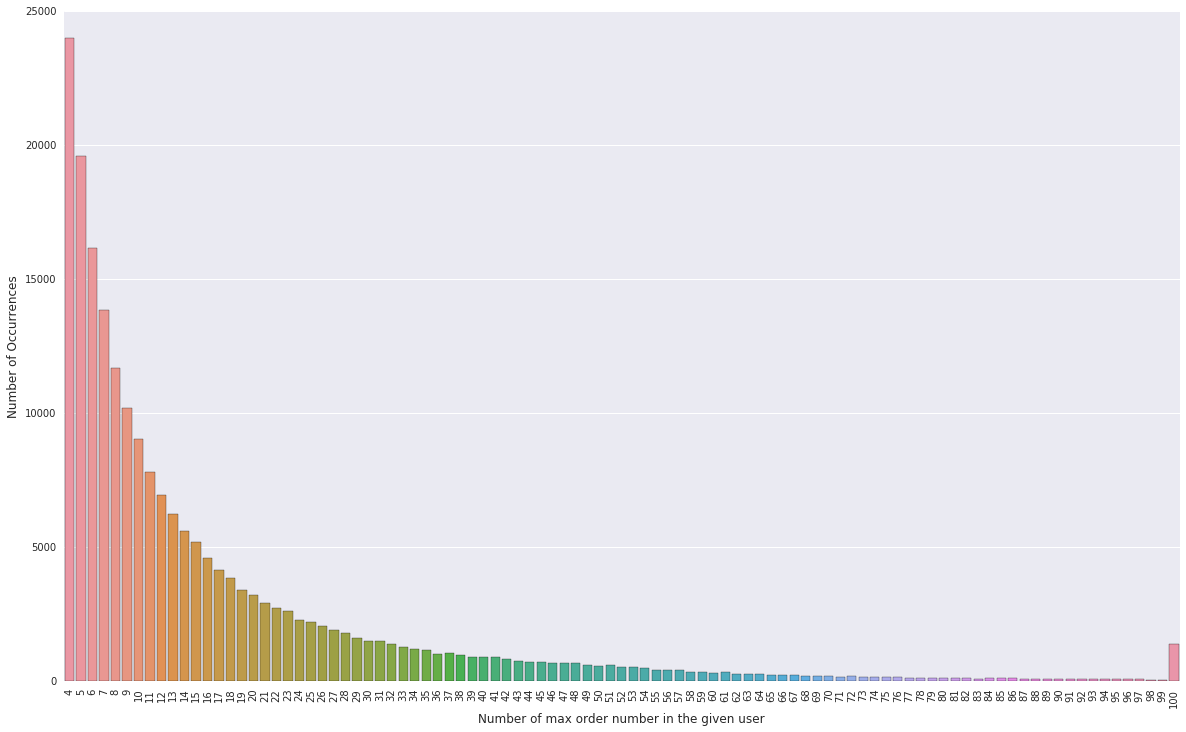

In [24]:
grouped_df =prior_train.groupby(['user_id'])['order_number'].agg(['max']).reset_index()
grouped_df=grouped_df['max'].value_counts()
plt.figure(figsize=(20,12))
sns.barplot(x=grouped_df.index, y=grouped_df.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of max order number in the given user', fontsize=12)
plt.xticks( rotation='vertical')
plt.show()

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">The distribution of the product counts per order is shown is the figure below. The highest product numbers that the users usually purchase per order are 5 and 6. 
 </span></div>

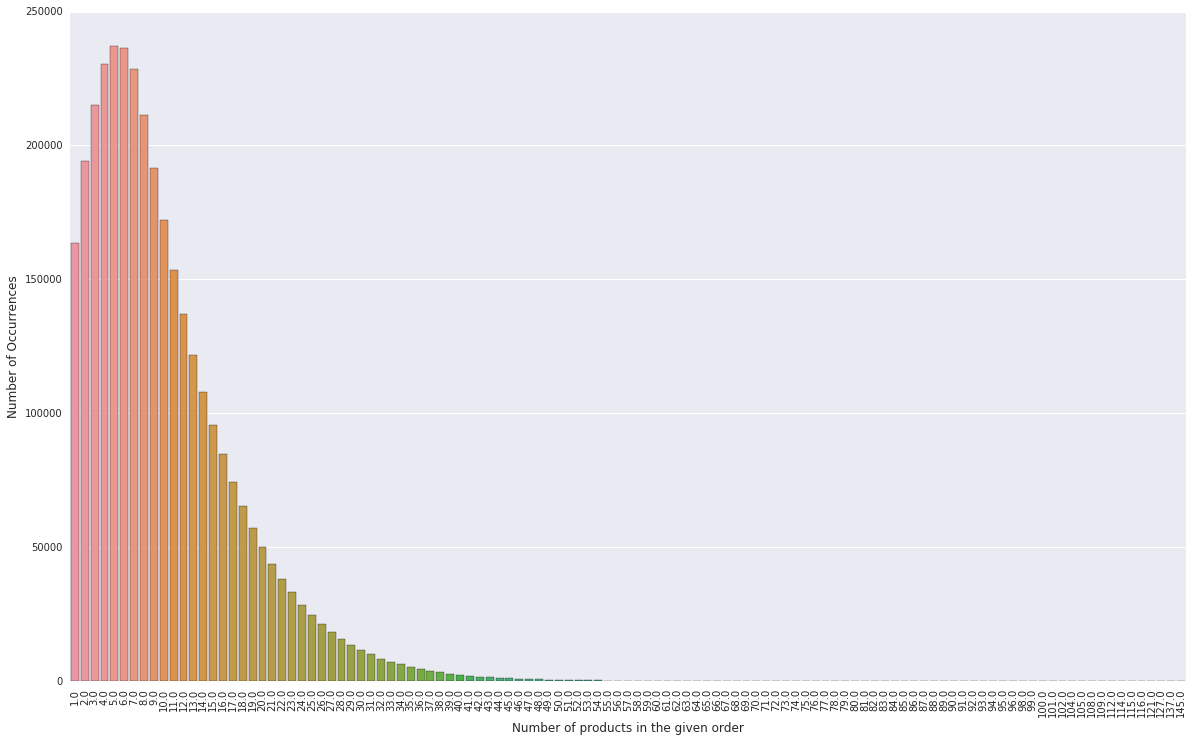

In [14]:
grouped_df =prior_train.groupby(['order_id'])['add_to_cart_order'].agg(['max']).reset_index()
grouped_df=grouped_df['max'].value_counts()
plt.figure(figsize=(20,12))
sns.barplot(x=grouped_df.index, y=grouped_df.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks( rotation='vertical')
plt.show()

<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:1.8em;">  
Let’s look at the relationship between the reorder rate and some attributes.  </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">The figure below shows the day 1 of week has highest reordered rate happened. Unfortunately there is no indication that the day 1 represent which day of week. 
 </span></div>

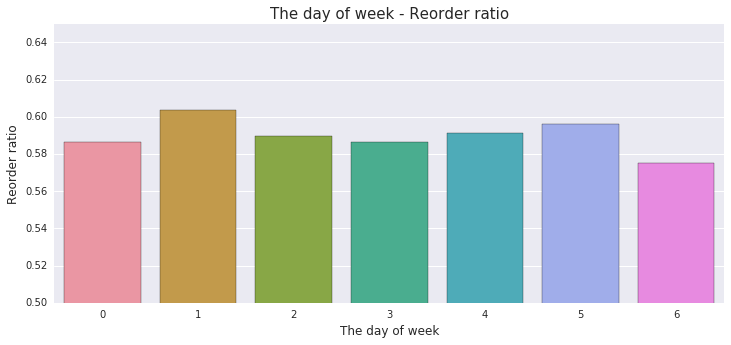

In [79]:
grouped_df =prior_train.groupby(['order_dow'])['reordered'].agg(['mean'])
plt.figure(figsize=(12,5))
sns.barplot(x=grouped_df.index, y=grouped_df['mean'].values)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('The day of week', fontsize=12)
plt.title("The day of week - Reorder ratio", fontsize=15)
plt.ylim([0.5,0.65])
plt.show()

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">The highest reordered rate happens around 6:00 – 9:00 when an order is placed. 
 </span></div>

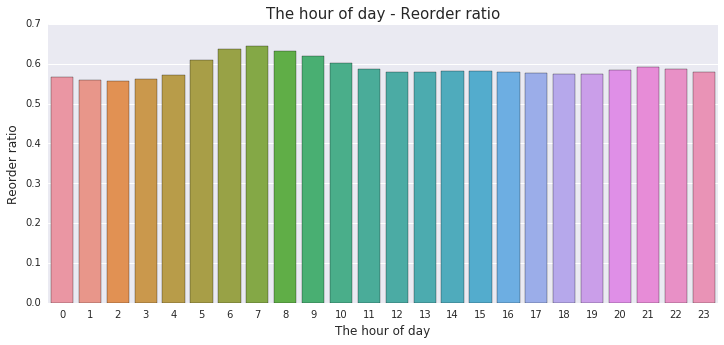

In [80]:
grouped_df =prior_train.groupby(['order_hour_of_day'])['reordered'].agg(['mean'])
plt.figure(figsize=(12,5))
sns.barplot(x=grouped_df.index, y=grouped_df['mean'].values)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('The hour of day', fontsize=12)
plt.title("The hour of day - Reorder ratio", fontsize=15)
plt.show()

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">It seems when the days between an order and its previous order are closer, the reordered rate becomes higher.
 </span></div>

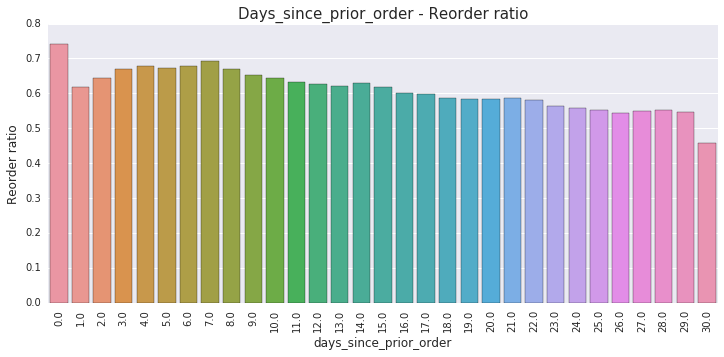

In [84]:
grouped_df =prior_train.groupby(['days_since_prior_order'])['reordered'].agg(['mean'])
plt.figure(figsize=(12,5))
sns.barplot(x=grouped_df.index, y=grouped_df['mean'].values)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('days_since_prior_order', fontsize=12)
plt.title("Days_since_prior_order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">Aisle ID Vs. reordered rate
 </span></div>

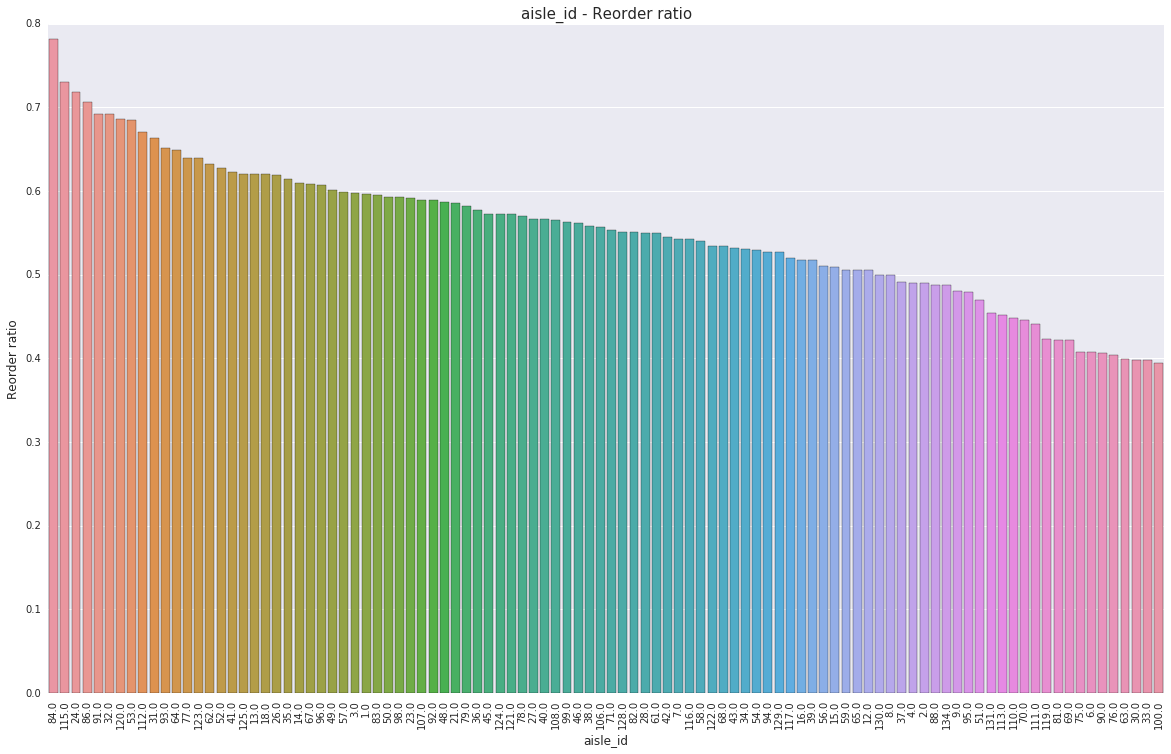

In [39]:
grouped_df =prior_train.groupby(['aisle_id'])['reordered'].agg(['mean']).sort_values(by='mean')[::-1][:100]
plt.figure(figsize=(20,12))
sns.barplot(x=range(100), y=grouped_df['mean'].values)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('aisle_id', fontsize=12)
plt.title("aisle_id - Reorder ratio", fontsize=15)
plt.xticks(range(100), grouped_df.index, rotation='vertical')
plt.show()

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">Department ID Vs. reordered rate
 </span></div>

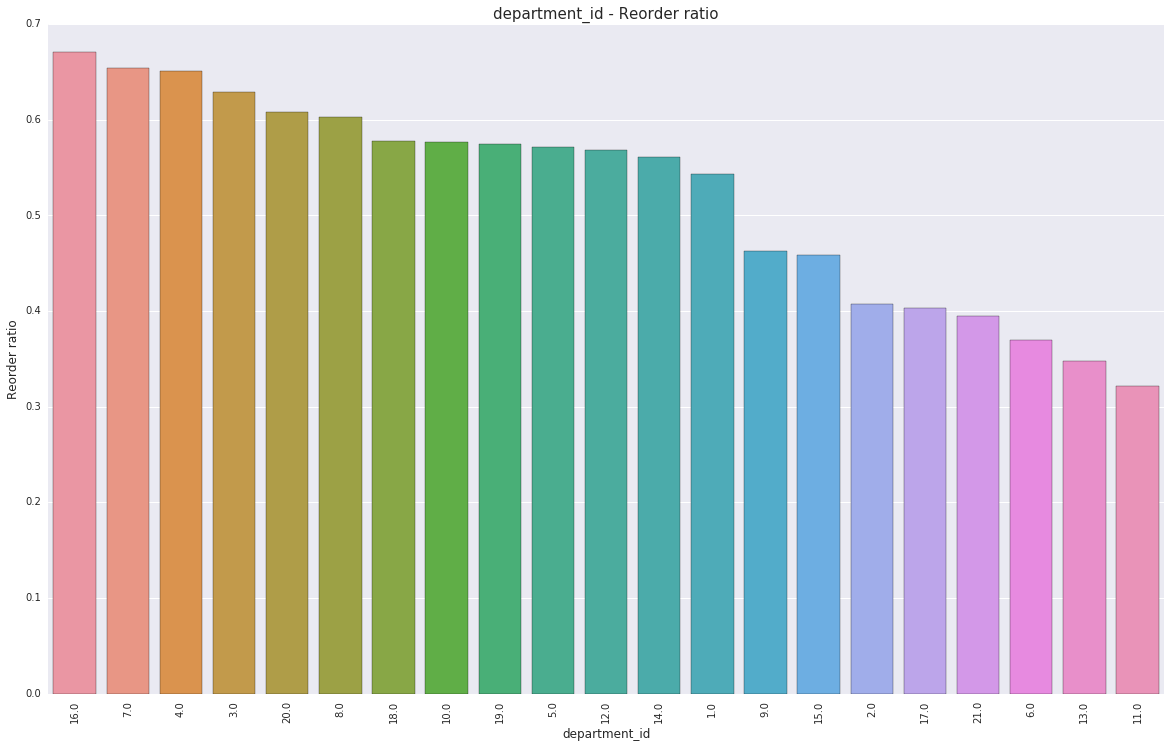

In [42]:
grouped_df =prior_train.groupby(['department_id'])['reordered'].agg(['mean']).sort_values(by='mean')[::-1]#[:100]
plt.figure(figsize=(20,12))
sns.barplot(x=range(len(grouped_df)), y=grouped_df['mean'].values)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('department_id', fontsize=12)
plt.title("department_id - Reorder ratio", fontsize=15)
plt.xticks(range(len(grouped_df)), grouped_df.index, rotation='vertical')
plt.show()

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">Suppose n is the n-th order for a user. The figure below show the reordered rate gets higher when n is larger. 
 </span></div>

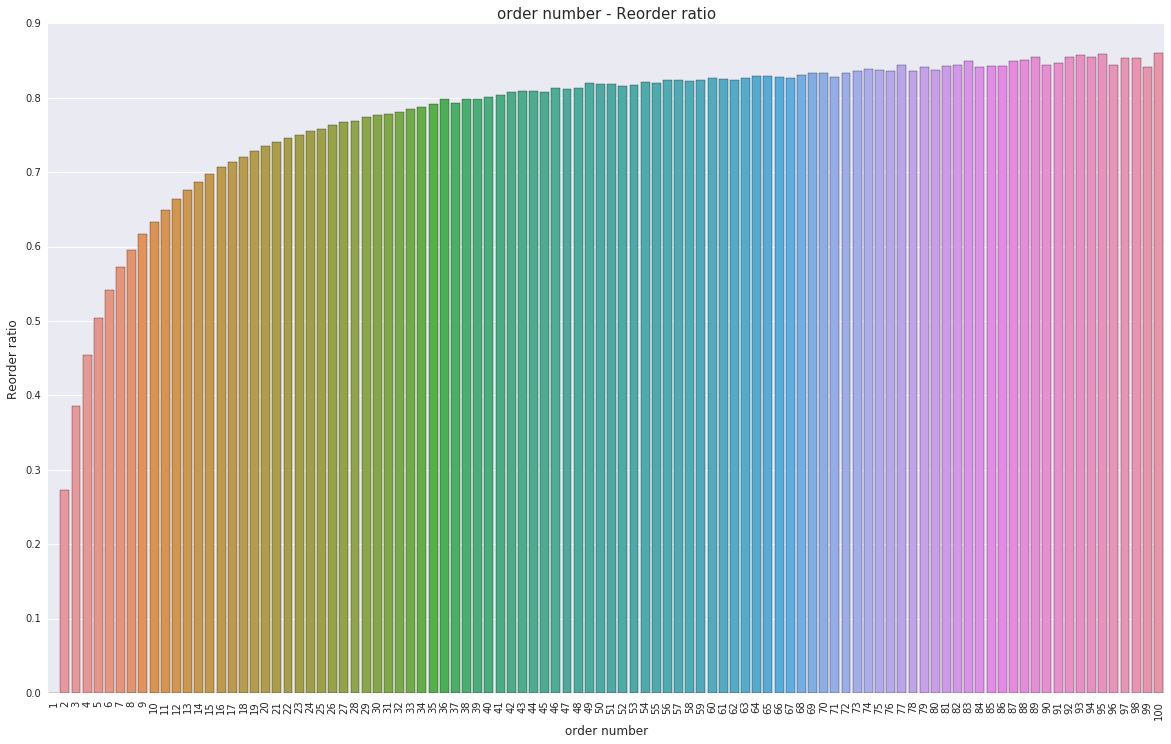

In [23]:
grouped_df =prior_train.groupby(['order_number'])['reordered'].agg(['mean'])
plt.figure(figsize=(20,12))
sns.barplot(x=grouped_df.index, y=grouped_df['mean'].values)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('order number', fontsize=12)
plt.title("order number - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">The order of adding a product to the cart has clear relationship with the reordered ratio. If a product is selected to the cart first, this product has the highest probability to be a reordered item. 
 </span></div>

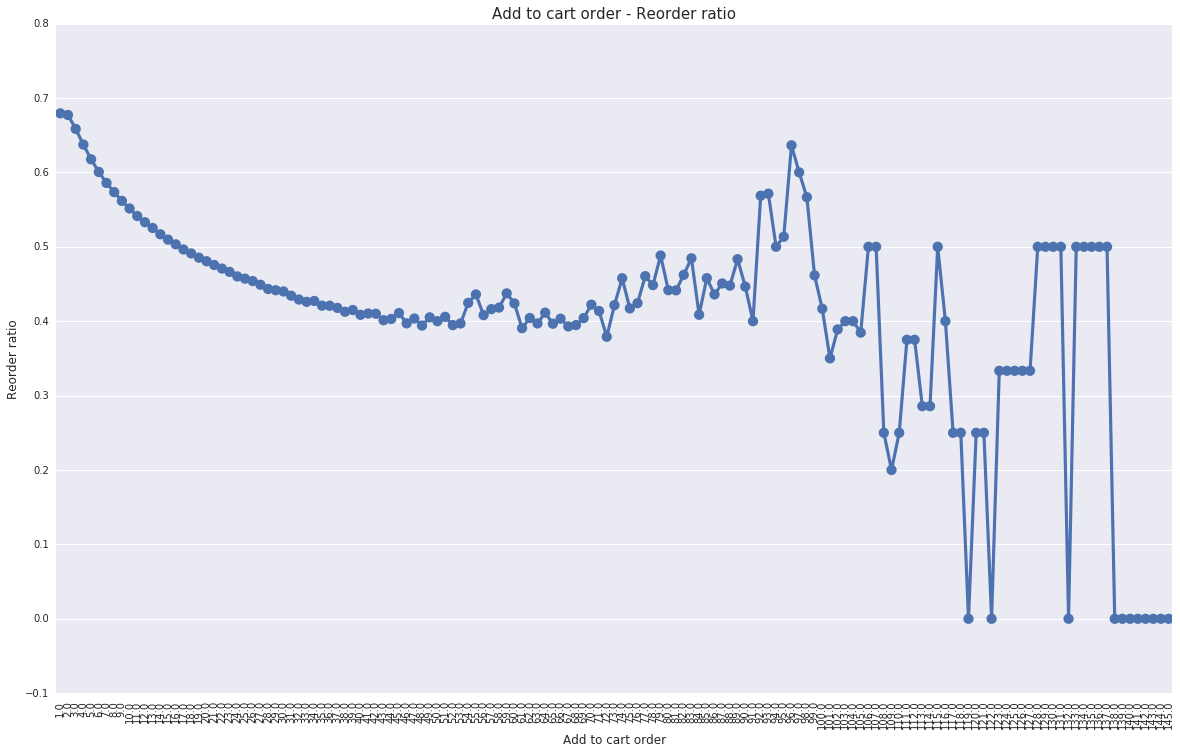

In [17]:
grouped_df =prior_train.groupby(['add_to_cart_order'])['reordered'].agg(['mean'])
plt.figure(figsize=(20,12))
sns.pointplot(grouped_df.index, grouped_df['mean'].values, alpha=0.8)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">This figure shows which product has high reordered rate.
 </span></div>

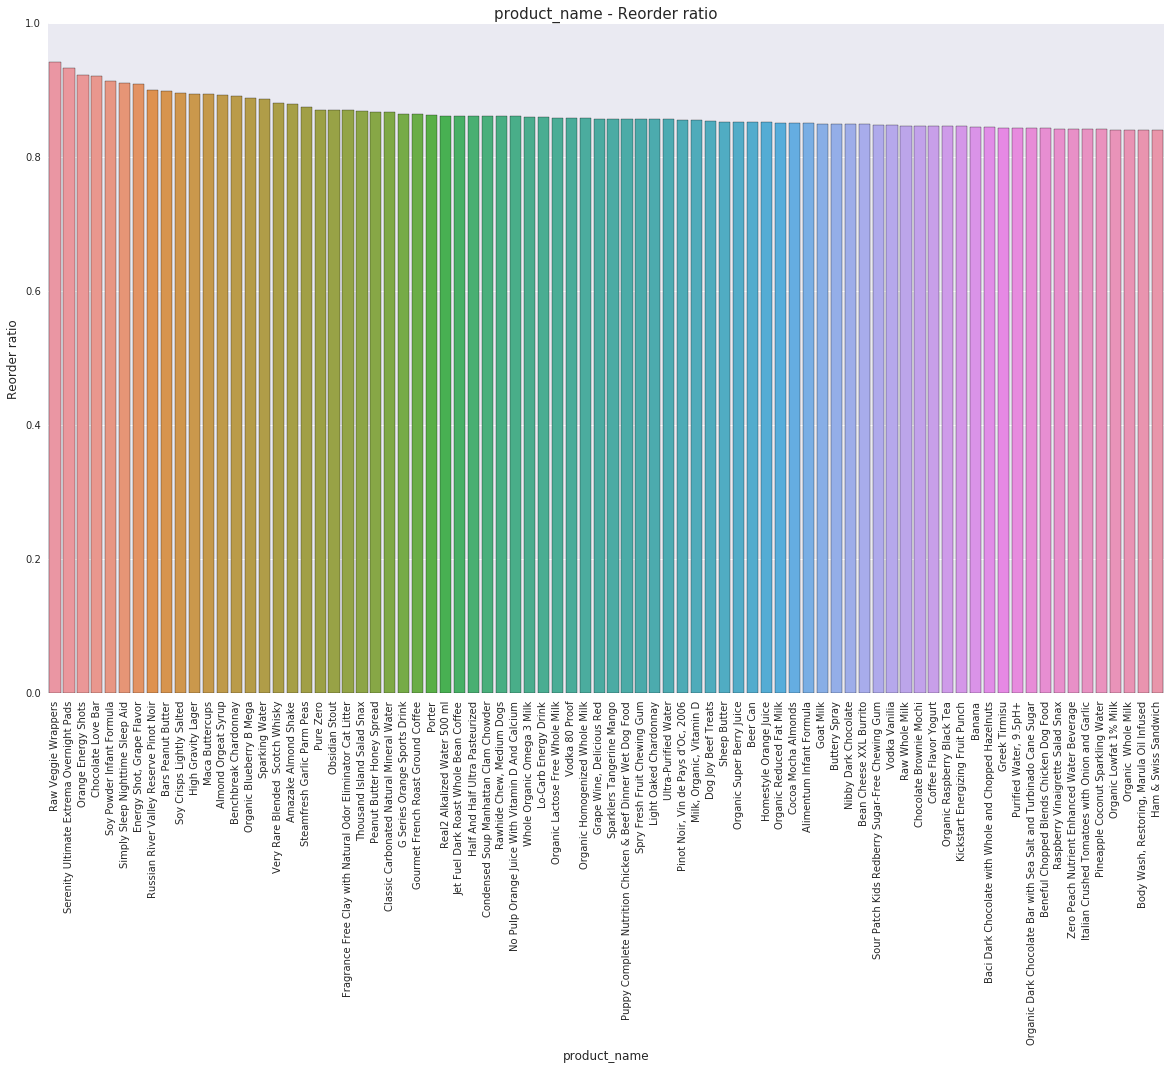

In [24]:
grouped_df =prior_train.groupby(['product_name'])['reordered'].agg(['mean']).reset_index().\
sort_values(by='mean')[::-1][:80]
plt.figure(figsize=(20,12))
sns.barplot(x=grouped_df.product_name.values, y=grouped_df['mean'].values)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('product_name', fontsize=12)
plt.title("product_name - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()